# Data Loading and Cleaning
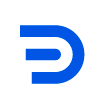

## In this workbook, I will load and clean the data sets from Twitter. One element of this is seperating the hashtags from the data source for analysis and matching them up to a list of predefined conspiracy hashtags

## Downloads
### Downloads

In [ ]:
# imports
import os
import itertools
import collections
from collections import Counter
import re
import numpy as np

import tweepy as tw
import pandas as pd
import string

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# download stopwords, punkt and wordnet packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# API key
api_key = config.api_key
secret = config.secret

In [ ]:
auth = tw.AppAuthHandler(api_key, secret)
api = tw.API(auth, wait_on_rate_limit=True)

### Define the Key Search Terms 

In [ ]:
# define hashtag search terms
# NB: they are case sensitive
search_coronavirus = '#coronavirus'
search_covid = '#covid'
search_covid19 = '#covid19'
search_virus = '#virus'
search_vaccine = '#vaccine'
search_pandemic = '#pandemic'

# # Other Options to search
# search_vaccine = '#vaccine'
# search_vaccinated = '#vaccinated'
# search_vaccination = '#vaccination'
# search_jab = '#jab'
# search_pfizer = '#pfizer'
# search_astrazeneca = '#astrazeneca'
# search_moderna = '#moderna'

## Dataframes Cleaned and Saved

### Cleaning 

In [ ]:
# Cleaning function
def tweet_clean(df):
# remove emojis from the text
    def remove_emoji(string):
        emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F" # emoticons
                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
                            u"\U0001F680-\U0001F6FF" # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)
# REGEX function   
    def regex_clean(txt, regex):
        return " ".join(re.sub(regex, "", txt).split())
# lemmatize tweet
    lemmatizer = WordNetLemmatizer()
    stpwrd = nltk.corpus.stopwords.words('english')
    stpwrd.extend(string.punctuation)
    def lemmatize_data(n):
        n = n.lower() 
        n = regex_clean(n, r'\s\d+\s')
        n = word_tokenize(n)
        n = [lemmatizer.lemmatize(word) for word in n]
        n = [lemmatizer.lemmatize(word) for word in n if word not in stpwrd]
        return n
# stem tweet
    p_stemmer = PorterStemmer()
    def stem_data(n):
        n = n.lower() 
        n = regex_clean(n, r'\s\d+\s')
        n = word_tokenize(n)
        n = [p_stemmer.stem(word) for word in n]
        n = [p_stemmer.stem(word) for word in n if word not in stpwrd]
        return n
# lancaster stem tweet
    def lanc_stemmed(df):
        df['split'] = df['cleaned'].apply(lambda x: str(x).lower())
        df['split'] = df.split
        df['split'].replace('^[0-9]+$','',inplace=True)
        for punc in string.punctuation:
            df['split'] = df.split.str.replace(punc,'')
        df['split'] = df['split'].apply(lambda x: [item for item in str(x).split() if item not in stopwords.words('english')])
        df['split'] = df['split'].apply(lambda x: [LancasterStemmer().stem(a) for a in x])
        return df

# apply cleaning functions to dataframe
# find all hashtags
    df['hashtag'] = df['tweet'].apply(lambda x: re.findall(r"#(\w+)", x))
# clean dataframe
    df['cleaned'] = df['tweet'].apply(str.lower)
  
    regex_to_clean = ['(@.+?)\s',
                      '\s\d+\s']
    for reg in regex_to_clean:
        df['cleaned'] = df['cleaned'].apply(regex_clean, regex=reg)
        df['cleaned'] = df['cleaned'].apply(remove_emoji)
# tokenize tweet  
    df['tokens'] = df['cleaned'].apply(word_tokenize)
# lemmatize tweet  
    df['lemmatized'] = df['cleaned'].apply(lemmatize_data)
# stem tweet
    df['stemmed'] = df['cleaned'].apply(stem_data)
# lancaster stem tweet
    df = lanc_stemmed(df)
# return cleaned dataframe
    return df

### Coronavirus Dataframe Cleaned and Saved

In [ ]:
## call a cursor item in the twitter library
# use api search
# this item generator collects 1000 items and if we loop through it we can collect all 1000 of our tweets in a dataframe
######### SORT DATES
tweets_coronavirus = tw.Cursor(api.search,
                   q = search_coronavirus,
                   lang ='en',
                   fromDate = '202002010000',
                   toDate = '202118060000',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_coronavirus

In [ ]:
# create dataframe
tweet_coronavirus = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_coronavirus])

In [ ]:
# rename dataframe columns
tweet_coronavirus.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [ ]:
tweet_coronavirus = tweet_clean(tweet_coronavirus)

In [ ]:
#explore datatypes
tweet_coronavirus.dtypes

tweet                   object
user                    object
location                object
date            datetime64[ns]
id                       int64
source                  object
favourites               int64
retweets                 int64
tweet_length             int64
hashtag                 object
cleaned                 object
tokens                  object
lemmatized              object
stemmed                 object
split                   object
dtype: object

In [ ]:
tweet_coronavirus

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,"More than 468,500 people have died of the nove...",Mojahedineng,IRAN,2021-11-01 16:00:02,1455202985496121348,Twitter Web App,47,56,190,"[coronavirus, Iran]","more than 468,500 people have died of the nove...","[more, than, 468,500, people, have, died, of, ...","[468,500, people, died, novel, coronavirus, in...","[468,500, peopl, die, novel, coronaviru, incit...","[468500, peopl, died, novel, coronavir, int, c..."
1,"3,428,959 people in Scotland have been tested ...",scotgov,Scotland,2021-11-01 14:01:45,1455173219233718279,Twitter Web App,66,31,303,[coronavirus],"3,428,959 people in scotland have been tested ...","[3,428,959, people, in, scotland, have, been, ...","[3,428,959, people, scotland, tested, coronavi...","[3,428,959, peopl, scotland, test, coronaviru,...","[3428959, peopl, scotland, test, coronavir, to..."
2,"#Iran Coronavirus Update\n\nMore than 467,800 ...",Mojahedineng,IRAN,2021-10-31 21:30:00,1454923634083090437,Twitter Web App,35,38,252,"[Iran, coronavirus]","#iran coronavirus update more than 467,800 peo...","[#, iran, coronavirus, update, more, than, 467...","[iran, coronavirus, update, 467,800, people, d...","[iran, coronaviru, updat, 467,800, peopl, die,...","[ir, coronavir, upd, 467800, peopl, died, nove..."
3,RT @NewsMedical: SARS-CoV-2 variants neutraliz...,FredNatLab,"Frederick, MD",2021-11-02 16:25:39,1455571820111826949,TweetDeck,0,3,140,"[Nanobodies, SARSCoV2, Coronavirus, COVID, cam]",rt sars-cov-2 variants neutralized by camel na...,"[rt, sars-cov-2, variants, neutralized, by, ca...","[rt, sars-cov-2, variant, neutralized, camel, ...","[rt, sars-cov-2, variant, neutral, camel, nano...","[rt, sarscov2, vary, neut, camel, nanobody, ht..."
4,No #medication/#vaccine guarantees a lack of s...,jryoumans,,2021-11-02 16:25:20,1455571738000084995,Twitter Web App,0,0,253,"[medication, vaccine, COVID19, Trump, shot, co...",no #medication/#vaccine guarantees a lack of s...,"[no, #, medication/, #, vaccine, guarantees, a...","[medication/, vaccine, guarantee, lack, side, ...","[medication/, vaccin, guarant, lack, side, eff...","[medicationvaccin, guar, lack, sid, effect, re..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,RT @Jerusalem_Post: Antibody levels decrease r...,Socialistdawn,,2021-10-31 16:31:15,1454848452073070592,Twitter for iPad,0,934,140,[],rt antibody levels decrease rapidly after two ...,"[rt, antibody, levels, decrease, rapidly, afte...","[rt, antibody, level, decrease, rapidly, two, ...","[rt, antibodi, level, decrea, rapidli, two, do...","[rt, antibody, level, decreas, rapid, two, dos..."
996,Kaua‘i WaVeS is up! https://t.co/hHK2uGj3qQ #G...,Go_Kauai,"Kauai, Hawaii",2021-10-31 16:31:15,1454848451720716289,Paper.li,1,0,180,"[GoKauai, Hawaii, PreserveKauai, KauaiWaves, K...",kaua‘i waves is up! https://t.co/hhk2ugj3qq #g...,"[kaua, ‘, i, waves, is, up, !, https, :, //t.c...","[kaua, ‘, wave, http, //t.co/hhk2ugj3qq, gokau...","[kaua, ‘, wave, http, //t.co/hhk2ugj3qq, gokau...","[kaua‘i, wav, httpstcohhk2ugj3qq, gokaua, hawa..."
997,Good God @CovidData2 Remember when @RealDonald...,SwerianBot,The Interwebs,2021-10-31 16:30:22,1454848229049315330,plague-bot,0,0,188,"[coronavirus, moronavirus]",good god remember when said 'think of it:count...,"[good, god, remember, when, said, 'think, of, ...","[good, god, remember, said, 'think, country, s...","[good, god, rememb, said, 'think, countri, som...","[good, god, rememb, said, think, itcountry, so..."
998,New COVID-19 Data at 2021-10-31 12:30:00 pm ED...,CovidData2,,2021-10-31 16:30:20,1454848223030415364,coronaData_Test,0,0,103,"[Coronavirus, COVID19, COVID_19]",new covid-19 data at 2021-10-31 12:30:00 pm ed...,"[new, covid-19, data, at, 2021-10-31, 12:30:00...","[new, covid-19, data, 2021-10-31, 12:30:00, pm...","[new, covid-19, data, 2021-10-31, 12:30:00, pm...","[new, covid19, dat, 20211031, 123000, pm, edt,

In [ ]:
#save dataframe to csv
from google.colab import files
tweet_coronavirus.to_csv('tweet_coronavirus.csv')
files.download("tweet_coronavirus.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Covid Dataframe Cleaned and Saved

In [ ]:
tweets_covid = tw.Cursor(api.search,
                   q = search_covid,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_covid

In [ ]:
tweet_covid = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_covid])

In [ ]:
tweet_covid.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [ ]:
tweet_covid = tweet_clean(tweet_covid)
tweet_covid

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,#COVID-19 self-test kits now available for as ...,bernamadotcom,"Kuala Lumpur, Malaysia",2021-11-01 11:54:12,1455141117763063811,Twitter for iPhone,1118,642,107,[COVID],#covid-19 self-test kits now available for as ...,"[#, covid-19, self-test, kits, now, available,...","[covid-19, self-test, kit, available, low, rm6...","[covid-19, self-test, kit, avail, low, rm6.90,...","[covid19, selftest, kit, avail, low, rm690, ht..."
1,Just watched someone on TV say all children 5 ...,PeterSchiff,Puerto Rico,2021-11-01 13:05:51,1455159149168414721,Twitter Web App,4889,509,279,"[vaccinated, Covid, vaccine]",just watched someone on tv say all childrenand...,"[just, watched, someone, on, tv, say, all, chi...","[watched, someone, tv, say, childrenand, older...","[watch, someon, tv, say, childrenand, older, g...","[watch, someon, tv, say, childrenand, old, get..."
2,Wondering how #JCVI failed to recommend #COVID...,martinmckee,London,2021-11-01 16:41:52,1455213513346015239,Twitter Web App,740,276,275,"[JCVI, COVID]",wondering how #jcvi failed to recommend #covid...,"[wondering, how, #, jcvi, failed, to, recommen...","[wondering, jcvi, failed, recommend, covid, va...","[wonder, jcvi, fail, recommend, covid, vaccin,...","[wond, jcvi, fail, recommend, covid, vaccin, 1..."
3,#healthcare providers must focus on providing ...,HITS_LLC,"Virginia, USA",2021-11-02 16:26:50,1455572116124884999,Hootsuite Inc.,0,0,219,"[healthcare, healthEquity, patients, digital, ...",#healthcare providers must focus on providing ...,"[#, healthcare, providers, must, focus, on, pr...","[healthcare, provider, must, focus, providing,...","[healthcar, provid, must, focu, provid, health...","[healthc, provid, must, foc, provid, healthequ..."
4,RT @IAFFNewsDesk: There is no health crisis am...,Gbro112794,,2021-11-02 16:26:49,1455572112576598021,Twitter for iPhone,0,86,148,"[NYC, COVID]",rt there is no health crisis among citizens of...,"[rt, there, is, no, health, crisis, among, cit...","[rt, health, crisis, among, citizen, nyc, amp,...","[rt, health, crisi, among, citizen, nyc, amp, ...","[rt, heal, cris, among, cit, nyc, amp, posit, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,RT @Zubhaque: This is NOT acceptable. Only 21%...,p1s70lpete,Hurstpierpoint•London•Amex ESU,2021-11-01 10:39:05,1455122214693613571,Twitter for iPhone,0,309,140,[],rt this is not acceptable. only 21% of 12-15yo...,"[rt, this, is, not, acceptable, ., only, 21, %...","[rt, acceptable, 21, 12-15yos, vaccinated, eng...","[rt, thi, accept, onli, 21, 12-15yo, vaccin, e...","[rt, acceiv, 21, 1215yos, vaccin, england, oct..."
996,RT @Zubhaque: This is NOT acceptable. Only 21%...,steveh11,"Essex, UK",2021-11-01 10:39:04,1455122212172800003,TweetDeck,0,309,140,[],rt this is not acceptable. only 21% of 12-15yo...,"[rt, this, is, not, acceptable, ., only, 21, %...","[rt, acceptable, 21, 12-15yos, vaccinated, eng...","[rt, thi, accept, onli, 21, 12-15yo, vaccin, e...","[rt, acceiv, 21, 1215yos, vaccin, england, oct..."
997,White House press secretary Jen Psaki tests po...,Sollencia,United States,2021-11-01 10:39:01,1455122199321382915,Twitter Web App,0,0,98,[Covid],white house press secretary jen psaki tests po...,"[white, house, press, secretary, jen, psaki, t...","[white, house, press, secretary, jen, psaki, t...","[white, hou, press, secretari, jen, psaki, tes...","[whit, hous, press, secret, jen, psak, test, p..."
998,RT @B52Malmet: Reminder that when Biden did no...,nstark1959,,2021-11-01 10:38:58,1455122186658795523,Twitter Web App,0,1824,140,[],rt reminder that when biden did not have a pea...,"[rt, reminder, that, when, biden, did, not, ha...","[rt, reminder, biden, peaceful, transfer, powe...","[rt, remind, biden, peac, transfer, power, als...","[rt, remind, bid, peac, transf, pow, also, inh..."


In [ ]:
# save to new csv
from google.colab import files
tweet_covid.to_csv('tweet_covid.csv')
files.download("tweet_covid.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Covid19 Dataframe Cleaned and Saved

In [ ]:
tweets_covid19 = tw.Cursor(api.search,
                   q = search_covid19,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_covid19

In [ ]:
tweet_covid19 = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_covid19])

In [ ]:
tweet_covid19.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [ ]:
tweet_covid19 = tweet_clean(tweet_covid19)
tweet_covid19

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,BREAKING — the pandemic’s true death toll is *...,DrEricDing,Washington DC & Virginia,2021-11-01 11:20:53,1455132732439334918,Twitter for iPhone,5057,2842,302,[COVID19],breaking — the pandemic’s true death toll is *...,"[breaking, —, the, pandemic, ’, s, true, death...","[breaking, —, pandemic, ’, true, death, toll, ...","[break, —, pandem, ’, true, death, toll, **not...","[break, —, pandemic’s, tru, dea, tol, mer, off..."
1,📍BOOSTERS needed for everyone age 16+: data is...,DrEricDing,Washington DC & Virginia,2021-11-02 12:57:28,1455519426816716802,Twitter for iPhone,1101,513,300,"[COVID19, MaskUp]",boosters needed for everyone age 16+: data is ...,"[boosters, needed, for, everyone, age, 16+, :,...","[booster, needed, everyone, age, 16+, data, cl...","[booster, need, everyon, age, 16+, data, clear...","[boost, nee, everyon, ag, 16, dat, clear, 34, ..."
2,Thousands of visitors were suddenly locked in ...,Quicktake,,2021-11-01 07:04:43,1455068265840001030,SocialFlow,2251,1454,271,[Covid19],thousands of visitors were suddenly locked in ...,"[thousands, of, visitors, were, suddenly, lock...","[thousand, visitor, suddenly, locked, shanghai...","[thousand, visitor, suddenli, lock, shanghai, ...","[thousand, visit, sud, lock, shangha, disneyla..."
3,"@paulholbrook5 Good morning Paul,\nHello #Virg...",Yolibeans,"Mill Valley, CA",2021-11-02 16:27:17,1455572227865255941,Twitter Web App,0,0,317,"[Virginia, TerryMcAuliffe, JoeBiden, Covid19, ...","good morning paul, hello #virginia! your vote ...","[good, morning, paul, ,, hello, #, virginia, !...","[good, morning, paul, hello, virginia, vote, t...","[good, morn, paul, hello, virginia, vote, terr...","[good, morn, paul, hello, virgin, vot, terrymc..."
4,@ShibInform SHIB TikTok trend? Everybody go ma...,daveybrown1992,,2021-11-02 16:27:16,1455572224807739399,Twitter for iPhone,0,0,274,"[ShibaArmy, shibainu, shiba, shib, Shibswap, S...",shib tiktok trend? everybody go make a video t...,"[shib, tiktok, trend, ?, everybody, go, make, ...","[shib, tiktok, trend, everybody, go, make, vid...","[shib, tiktok, trend, everybodi, go, make, vid...","[shib, tiktok, trend, everybody, go, mak, vide..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"RT @BernieSpofforth: Illogical, unscientific n...",linda_nobull,,2021-11-01 06:35:00,1455060787765157888,Twitter Web App,0,2141,140,[],"rt illogical, unscientific nonsense all for sh...","[rt, illogical, ,, unscientific, nonsense, all...","[rt, illogical, unscientific, nonsense, show, ...","[rt, illog, unscientif, nonsen, show, g20, lea...","[rt, illog, unscy, nonsens, show, g20, lead, w..."
996,#BREAKING: Australia has just recognised INDIA...,AdityaRajKaul,"New Delhi, India",2021-11-01 06:34:57,1455060778046820354,Twitter for iPhone,4575,871,147,"[BREAKING, COVAXIN, COVID19]",#breaking: australia has just recognised india...,"[#, breaking, :, australia, has, just, recogni...","[breaking, australia, ha, recognised, india, m...","[break, australia, ha, recogni, india, made, c...","[break, austral, recogn, ind, mad, covaxin, va..."
997,Just In | #BreakingNews \n\nHuge relief for Co...,NELiveTV,"Guwahati, India",2021-11-01 06:34:56,1455060770589265922,Twitter Web App,2,1,187,"[BreakingNews, Australia, Covaxin, COVID19]",just in | #breakingnews huge relief for covaxi...,"[just, in, |, #, breakingnews, huge, relief, f...","[breakingnews, huge, relief, covaxin, vaccinat...","[breakingnew, huge, relief, covaxin, vaccin, t...","[breakingnew, hug, reliev, covaxin, vaccin, tr..."
998,Oxford English Dictionary chooses 'Vax' as wor...,Sambad_English,Odisha,2021-11-01 06:34:54,1455060765552033797,Twitter Web App,2,0,105,"[Oxford, Vax, Covid19]",oxford english dictionary chooses 'vax' as wor...,"[oxford, english, dictionary, chooses, 'vax, '...","[oxford, english, dictionary, chooses, 'vax, w...","[oxford, english, dictionari, choo, 

In [ ]:
# save to new csv
from google.colab import files
tweet_covid19.to_csv('tweet_covid19.csv')
files.download("tweet_covid19.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Virus Dataframe Cleaned and Saved

In [ ]:
tweets_virus = tw.Cursor(api.search,
                   q = search_virus,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_virus

In [ ]:
tweet_virus = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_virus])

In [ ]:
tweet_virus.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [ ]:
tweet_virus = tweet_clean(tweet_virus)
tweet_virus

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,"Media: @JReinerMD to @AnaCabrera: ""Data from @...",Porter_Anderson,,2021-10-26 20:53:34,1453102525754888198,Hootsuite Inc.,86,18,295,"[UnitedStates, virus]","media: to ""data from suggests the vaccine is b...","[media, :, to, ``, data, from, suggests, the, ...","[medium, ``, data, suggests, vaccine, safe, ef...","[media, ``, data, suggest, vaccin, safe, effec...","[med, dat, suggest, vaccin, saf, effect, child..."
1,@JimWatsonOttawa @ottawacity @OttawaHealth @Ke...,TranspoMr,,2021-11-02 16:25:50,1455571866333192198,Twitter for iPhone,0,0,286,"[transmit, receive, covid, virus, vaccine, vac...",if you can still #transmit or #receive the #co...,"[if, you, can, still, #, transmit, or, #, rece...","[still, transmit, receive, covid, virus, reall...","[still, transmit, receiv, covid, viru, realli,...","[stil, transmit, receiv, covid, vir, real, vac..."
2,RT @RebeccaLAnders: This group thinks people a...,LostTogetherCda,Canada,2021-11-02 16:13:45,1455568825752055812,Twitter for iPhone,0,1,144,"[Vaccine, Virus, Pandemic]",rt this group thinks people are crazygetting a...,"[rt, this, group, thinks, people, are, crazyge...","[rt, group, think, people, crazygetting, vacci...","[rt, thi, group, think, peopl, crazyget, vacci...","[rt, group, think, peopl, crazyget, vaccin, vi..."
3,Wishing you very Happy Diwali from Team Pest Q...,pestquit,,2021-11-02 16:12:29,1455568505378508800,Twitter for Android,0,0,303,"[HappyDiwali, diwali, HappyDeepavali, SaalMuba...",wishing you very happy diwali from team pest q...,"[wishing, you, very, happy, diwali, from, team...","[wishing, happy, diwali, team, pest, quit, hap...","[wish, veri, happi, diwali, team, pest, quit, ...","[wish, happy, diwal, team, pest, quit, happydi..."
4,Who here has a bill to pay?\nDevil's Due by Ti...,TimArnzen,"Anchorage, AK",2021-11-02 16:09:25,1455567734222118913,Twitter Web App,1,1,274,"[free, horror, scifi, sciencefiction, thriller...",who here has a bill to pay? devil's due by tim...,"[who, here, has, a, bill, to, pay, ?, devil, '...","[ha, bill, pay, devil, 's, due, timothy, arnze...","[ha, bill, pay, devil, 's, due, timothi, arnze...","[bil, pay, devil, due, timothy, arnz, httpstco..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,RT @andygomez3dart: Finally this #halloween I ...,andygomez3dart,"Edinburgh, Scotland",2021-10-24 19:41:46,1452359682841063427,Twitter for Android,0,1,140,"[halloween, miniature, done, 3Dprinting, Covid...",rt finally this #halloween i got this #miniatu...,"[rt, finally, this, #, halloween, i, got, this...","[rt, finally, halloween, got, miniature, nearl...","[rt, final, thi, halloween, got, thi, miniatur...","[rt, fin, halloween, got, miny, near, don, 3dp..."
669,Political and religious power plays at work in...,Reveal_House,"Meridian, ID",2021-10-24 19:40:43,1452359417916112897,Reveal House Press,0,1,166,"[virus, epidemic, political, religious]",political and religious power plays at work in...,"[political, and, religious, power, plays, at, ...","[political, religious, power, play, work, worl...","[polit, religi, power, play, work, world, spir...","[polit, religy, pow, play, work, world, spir, ..."
670,@rozjonez @LBC @CharlieM_OBE @RachelSJohnson A...,CrazedUpWorld,Dark Side of The Moon,2021-10-24 19:38:23,1452358831414075394,Twitter for Android,0,0,254,[Virus],aspirin just proves your delusion the great pe...,"[aspirin, just, proves, your, delusion, the, g...","[aspirin, prof, delusion, great, people, n't, ...","[aspirin, prove, delu, great, peopl, n't, forc...","[aspirin, prov, delud, gre, peopl, ar, forc, t..."
671,"RT @UviPoznansky: Via ""@SSBazinet\n ✨ EVERYTHI...",AndyPennefather,South Taranaki District,2021-10-24 19:29:39,1452356634685042689,Twitter Web App,0,7,140,[],"rt via "" everything takes it out of you https:...","[rt, via, ``, everything, takes, it, out, of, ...","[rt, via, ``, everything

In [ ]:
# save to new csv
from google.colab import files
tweet_virus.to_csv('tweet_virus.csv')
files.download("tweet_virus.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Vaccine Dataframe Cleaned and Saved

In [ ]:
tweets_vaccine = tw.Cursor(api.search,
                   q = search_vaccine,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_vaccine

In [ ]:
tweet_vaccine = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_vaccine])

In [ ]:
tweet_vaccine.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [ ]:
tweet_vaccine = tweet_clean(tweet_vaccine)
tweet_vaccine

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,Just watched someone on TV say all children 5 ...,PeterSchiff,Puerto Rico,2021-11-01 13:05:51,1455159149168414721,Twitter Web App,4889,509,279,"[vaccinated, Covid, vaccine]",just watched someone on tv say all childrenand...,"[just, watched, someone, on, tv, say, all, chi...","[watched, someone, tv, say, childrenand, older...","[watch, someon, tv, say, childrenand, older, g...","[watch, someon, tv, say, childrenand, old, get..."
1,"In our Taiwan culture, a circle carries meanin...",bikhim,Taiwan,2021-11-01 13:14:52,1455161418689519617,Twitter for iPhone,3607,227,259,"[vaccine, StrongerTogether]","in our taiwan culture, a circle carries meanin...","[in, our, taiwan, culture, ,, a, circle, carri...","[taiwan, culture, circle, carry, meaning, whol...","[taiwan, cultur, circl, carri, mean, wholesom,...","[taiw, cult, circ, carry, mean, wholesom, ful,..."
2,1 in 6 #NewYorkCity workers employed by the ci...,EpochTimes,"New York, USA",2021-10-31 21:10:01,1454918606521786368,Buffer,1044,297,156,"[NewYorkCity, Vaccine, COVID19]",1 in#newyorkcity workers employed by the city ...,"[1, in, #, newyorkcity, workers, employed, by,...","[1, newyorkcity, worker, employed, city, decli...","[1, newyorkc, worker, employ, citi, declin, ge...","[1, innewyorkc, work, employ, city, declin, ge..."
3,RT @VaccToken: VACCine $VACC multiple exchange...,vya0902,"DKI Jakarta, Indonesia",2021-11-02 16:27:54,1455572383436132357,Twitter for Android,0,56,126,"[VACC, VACCine, ETH, BNB, CAKE, DEX]",rt vaccine $vacc multiple exchanges listing so...,"[rt, vaccine, $, vacc, multiple, exchanges, li...","[rt, vaccine, vacc, multiple, exchange, listin...","[rt, vaccin, vacc, multipl, exchang, list, soo...","[rt, vaccin, vacc, multipl, exchang, list, soo..."
4,RT @Frimley_CCG: The #Coronavirus #Vaccine Bus...,ilovelucy57,,2021-11-02 16:27:45,1455572349449908224,Echofon,0,4,147,"[Coronavirus, Vaccine, Slough, Datchet]",rt the #coronavirus #vaccine bus offers 1st&am...,"[rt, the, #, coronavirus, #, vaccine, bus, off...","[rt, coronavirus, vaccine, bus, offer, 1st, am...","[rt, coronaviru, vaccin, bu, offer, 1st, amp, ...","[rt, coronavir, vaccin, bus, off, 1stamp2nd, d..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,RT @MackGray4: Wonder what the #Factcheckers m...,Duchess6th,,2021-10-31 15:14:18,1454829088879824914,Twitter Web App,0,22,140,"[Factcheckers, vaccine]",rt wonder what the #factcheckers make of this ...,"[rt, wonder, what, the, #, factcheckers, make,...","[rt, wonder, factcheckers, make, regarding, va...","[rt, wonder, factcheck, make, thi, regard, vac...","[rt, wond, factcheck, mak, regard, vaccin, tra..."
996,For anyone trying to link Sergio Aguero’s card...,adamtweets85,"Newcastle Upon Tyne, England",2021-10-31 15:14:01,1454829016456830984,Twitter for iPhone,3,0,274,"[COVID19, vaccine]",for anyone trying to link sergio aguero’s card...,"[for, anyone, trying, to, link, sergio, aguero...","[anyone, trying, link, sergio, aguero, ’, card...","[anyon, tri, link, sergio, aguero, ’, cardiac,...","[anyon, try, link, sergio, aguero’s, cardiac, ..."
997,What the hell is happening!? #vaccine https://...,masonjc88,"England, United Kingdom",2021-10-31 15:13:26,1454828869979197443,Twitter for iPhone,0,0,61,[vaccine],what the hell is happening!? #vaccine https://...,"[what, the, hell, is, happening, !, ?, #, vacc...","[hell, happening, vaccine, http, //t.co/8zmym5...","[hell, happen, vaccin, http, //t.co/8zmym5dokr]","[hel, hap, vaccin, httpstco8zmym5dokr]"
998,RT @Lougise: 🥧#Halloween’s Scary #SupplyChain ...,Lougise,,2021-10-31 15:13:14,1454828820264103938,Twitter for iPad,0,1,139,"[Halloween, SupplyChain, Cuomo, WorldSeries, V...",rt 🥧#halloween’s scary #supplychain mess #cuom...,"[rt, 🥧, #, halloween, ’, s, scary, #, supplych...","[rt, 🥧, halloween, ’, scary, supplychain, mess...","[rt, 🥧, halloween, ’, scari, supplychain, mess.

In [ ]:
# save to new csv
from google.colab import files
tweet_vaccine.to_csv('tweet_vaccine.csv')
files.download("tweet_vaccine.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Pandemic Dataframe Cleaned and Saved

In [ ]:
tweets_pandemic = tw.Cursor(api.search,
                   q = search_pandemic,
                   lang ='en',
                   fromDate = '2020/02/01',
                   toDate = '2020/12/31',
                   tweet_mode = 'extended',
                   min_retweets = 50,
                   result_type = 'mixed').items(1000)

tweets_pandemic

In [ ]:
tweet_pandemic = pd.DataFrame(data=[[tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.id, tweet.source, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)]for tweet in tweets_pandemic])

In [ ]:
tweet_pandemic.columns = ['tweet', 'user', 'location', 'date', 'id', 'source', 'favourites', 'retweets', 'tweet_length']

In [ ]:
tweet_pandemic = tweet_clean(tweet_pandemic)
tweet_pandemic

,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split
0,GRIM #PANDEMIC STATS:\n\n◼️ U.S. ∼15% of globa...,peterdaou,,2021-11-01 15:45:18,1455199278461247500,Twitter Web App,87,41,272,"[PANDEMIC, COVID]",grim #pandemic stats: u.s. ∼15% of global #cov...,"[grim, #, pandemic, stats, :, u.s., ∼15, %, of...","[grim, pandemic, stats, u.s., ∼15, global, cov...","[grim, pandem, stat, u.s., ∼15, global, covid,...","[grim, pandem, stat, us, ∼15, glob, covid, dea..."
1,As restaurant owners struggled to stay afloat ...,EpochTimes,"New York, USA",2021-11-02 03:25:01,1455375367145984004,Buffer,26,22,275,"[Pandemic, LosAngeles]",as restaurant owners struggled to stay afloat ...,"[as, restaurant, owners, struggled, to, stay, ...","[restaurant, owner, struggled, stay, afloat, p...","[restaur, owner, struggl, stay, afloat, dure, ...","[resta, own, struggled, stay, aflo, pandem, re..."
2,"#COP26, Draghi: I am proud of the efforts made...",Palazzo_Chigi,,2021-11-01 19:13:50,1455251756489887753,Twitter Web App,76,15,296,"[COP26, EU, NGEU, pandemic]","#cop26, draghi: i am proud of the efforts made...","[#, cop26, ,, draghi, :, i, am, proud, of, the...","[cop26, draghi, proud, effort, made, italy, eu...","[cop26, draghi, proud, effort, made, itali, eu...","[cop26, dragh, proud, effort, mad, ita, eu, ng..."
3,Love that our neighborhood @Starbucks models s...,edboyle,Seattle,2021-11-02 16:27:39,1455572320697806850,Twitter for iPhone,0,0,278,"[Tacoma, NorthTacoma, GritCity, PierceCounty, ...","love that our neighborhood models safe, respon...","[love, that, our, neighborhood, models, safe, ...","[love, neighborhood, model, safe, responsible,...","[love, neighborhood, model, safe, respon, mask...","[lov, neighb, model, saf, respons, mask, among..."
4,RT @floricuas: Daniella Levine Cava @MayorDani...,CheryleJ0806,"Georgia, USA",2021-11-02 16:27:33,1455572299084664832,Twitter for iPhone,0,27,140,[],rt daniella levine cava miami-dade county’s fi...,"[rt, daniella, levine, cava, miami-dade, count...","[rt, daniella, levine, cava, miami-dade, count...","[rt, daniella, levin, cava, miami-dad, counti,...","[rt, daniell, levin, cav, miamidad, county’s, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,RT @GamianE: 📢 SURVEY FOR PATIENTS AND CLINICI...,MentalHealthBo5,,2021-11-01 09:39:38,1455107255389589505,Mental Health Bot 1,0,18,140,"[pandemic, mentalhealth]",rt survey for patients and clinicians: what ha...,"[rt, survey, for, patients, and, clinicians, :...","[rt, survey, patient, clinician, ha, impact, p...","[rt, survey, patient, clinician, ha, impact, p...","[rt, survey, paty, clin, impact, pandem, deliv..."
996,RT @GamianE: 📢 SURVEY FOR PATIENTS AND CLINICI...,Sofia04052020,Spero la migliore,2021-11-01 09:39:33,1455107233453420544,Twitter for Android,0,18,140,"[pandemic, mentalhealth]",rt survey for patients and clinicians: what ha...,"[rt, survey, for, patients, and, clinicians, :...","[rt, survey, patient, clinician, ha, impact, p...","[rt, survey, patient, clinician, ha, impact, p...","[rt, survey, paty, clin, impact, pandem, deliv..."
997,One month on.. thank you for all your support ...,lisastanleysing,Ireland/U.K.,2021-11-01 09:38:15,1455106907467886599,Twitter for iPhone,5,4,275,"[lisastanleymusic, covid19, pandemic, light, h...",one month on.. thank you for all your support ...,"[one, month, on.., thank, you, for, all, your,...","[one, month, on.., thank, support, song.., ple...","[one, month, on.., thank, support, thi, song.....","[on, mon, thank, support, song, pleas, keep, s..."
998,#G20Summit ‘fruitful’ in addressing issues of ...,the_news_21,"Mumbai, India",2021-11-01 09:38:15,1455106906826035204,Twitter for Android,0,0,278,"[G20Summit, PMModi, PMModiInItaly, G20RomeSumm...",#g20summit ‘fruitful’ in addressing issues of ...,"[#, g20summit, ‘, fruitful, ’, in, addressing,...","[g20summit, ‘, fruitful, ’, addressing, issue,...","[g20summit, ‘, fruit, ’, addre

In [ ]:
# save to new csv
from google.colab import files
tweet_pandemic.to_csv('tweet_pandemic.csv')
files.download("tweet_pandemic.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TO DO

1. Load Seperate Datasets: coronavirus, covid, covid19, pandemic, virus
2. Save these Datasets to individual files
3. Clean the data: - remove stopwords, remove punctuation, make new column for hashtags, 
4. Explore all retweets: date and location
5. Identify hashtags that are indicative of conspiracy theories: make word cloud of these hashtags e.g. anti semitism, anti-chinese rhetoric, bat soup, general cover up, 5G
6. Isolate the tweets that have these hashtags and explore
7. conspiracies, hate speech and incitement to violence
8. group according to 5g, anti-chinese rhetoric, anti-semitic etc.. and have time series graph

## Hashtag EDA

### Hashtag EDA Coronvairus

In [ ]:
# Create List with all hashtags in
def hashtags(df):
    
    hashtag_list = []

    for item in df:
        for value in item:
            hashtag_list.append(value)

    return hashtag_list

In [ ]:
# convert all hashtags to lowercase to help filter duplicates
def lowercase(list):
    for i in range(len(list)):
        list[i] = list[i].lower()

    return list

In [ ]:
def get_hashtags_list(df):
    h_list = hashtags(df.hashtag)
    h_list_lower = lowercase(h_list)
    h_list_count = dict(zip(list(h_list_lower),[list(h_list_lower).count(i) for i in list(h_list_lower)]))
    return h_list_count

In [ ]:
coronavirus_hashtags = get_hashtags_list(tweet_coronavirus)

### Hashtag EDA Covid

In [ ]:
covid_hashtags = get_hashtags_list(tweet_covid)

### Hashtag EDA Covid19

In [ ]:
covid19_hashtags = get_hashtags_list(tweet_covid19)

### Hashtag EDA Virus

In [ ]:
virus_hashtags = get_hashtags_list(tweet_virus)

### Hashtag EDA Vaccine

In [ ]:
vaccine_hashtags = get_hashtags_list(tweet_vaccine)

### Hashtag EDA Pandemic

In [ ]:
pandemic_hashtags = get_hashtags_list(tweet_pandemic)

## Total Chosen Hashtags

In [ ]:
complete_hashtags_list = ['chinaliedpeopledied', 'chinesevirus', 'fauci', 'lableaktheory', 'lableak', 'magneticpower', 'notocoronavirusvaccines', 'wuhanlab', 'ccp_is_terrorist', 'ccpbiowarfare', 'fakenewsalert', 'fbi', 'kungflu', 'plandemic', 'sideeffects', 'statemedia', 'surveillancestate', 'terrorism', 'terrorists', 'theliberalmediaistheenemy', 'vaccinesideeffects', 'covidbraindamage', 'disinformation', '5g', 'aliens', 'antivax', 'billgates', 'biologicalweapon', 'bioweapon', 'bioweapons', 'fakenews' 'capitalismisthevirus', 'ccp_is_terrorist', 'ccpliedpeopledied', 'chinamustpay', 'chinazi', 'deathsentenceforfauci', 'democratsarecorrupt', 'democratsareevil', 'fauciliedpeopledied', 'gatesfoundation', 'usaexposed', 'ccpvirus', 'hoax', 'bigpharma', 'chinaagenda', 'cyberattack', 'cybersecurity', 'cyberthreats', 'faucigate', 'communismisthevirus', 'fakenews', 'fakedemic', 'chinavirus', 'coverup', 'father_of_corona', 'fatherofcorona', 'moronavirus', 'plague', 'report_china', 'report_china_father_of_corona', 'reportchina', 'hydroxychloroquine', '5gmast', 'magnetic', 'batsoup', 'deepstate', 'covid19hoax', 'trumpvirus']

I now want to join the following dataframes together, and make a word cloud looking at the count of the complete_hashtag_lists

In [ ]:
coronavirus = pd.read_csv("/content/tweet_coronavirus.csv")
covid = pd.read_csv("/content/tweet_covid.csv")
covid19 = pd.read_csv("/content/tweet_covid19.csv")
pandemic = pd.read_csv("/content/tweet_pandemic.csv")
vaccine = pd.read_csv("/content/tweet_vaccine.csv")
virus = pd.read_csv("/content/tweet_virus.csv")

In [ ]:
df1 = coronavirus.append(covid, ignore_index = True)
df2 = df1.append(covid19, ignore_index = True)
df3 = df2.append(pandemic, ignore_index = True)
df4 = df3.append(vaccine, ignore_index = True)
df = df4.append(virus, ignore_index = True)

In [ ]:
df.shape

(5673, 16)

In [ ]:
df.to_csv('covid.csv')

In [ ]:
import ast

def conspiracy(x):
    consp_list = np.array([])

    x = ast.literal_eval(x)

    for i in x:
        if i.lower() in complete_hashtags_list:
            consp_list = np.append(consp_list, [i])
            
    print(consp_list)
    return consp_list

In [ ]:
# create hashtag2, which only includes hashtags that are in complete_hashtags_list
df['hashtag2'] = df.hashtag.apply(conspiracy)

Streaming output truncated to the last 5000 lines.
[]
[]
[]
['moronavirus']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['moronavirus']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['plandemic']
[]
[]
['VaccineSideEffects']
[]
[]
[]
[]
[]
[]
[]
[]
['fauci' 'lableak']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['moronavirus']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['CCPVirus']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [ ]:
df.head()

,Unnamed: 0,tweet,user,location,date,id,source,favourites,retweets,tweet_length,hashtag,cleaned,tokens,lemmatized,stemmed,split,hashtag2
0,0,"More than 468,500 people have died of the nove...",Mojahedineng,IRAN,2021-11-01 16:00:02,1455202985496121348,Twitter Web App,47,56,190,"['coronavirus', 'Iran']","more than 468,500 people have died of the nove...","['more', 'than', '468,500', 'people', 'have', ...","['468,500', 'people', 'died', 'novel', 'corona...","['468,500', 'peopl', 'die', 'novel', 'coronavi...","['468500', 'peopl', 'died', 'novel', 'coronavi...",[]
1,1,"3,428,959 people in Scotland have been tested ...",scotgov,Scotland,2021-11-01 14:01:45,1455173219233718279,Twitter Web App,66,31,303,['coronavirus'],"3,428,959 people in scotland have been tested ...","['3,428,959', 'people', 'in', 'scotland', 'hav...","['3,428,959', 'people', 'scotland', 'tested', ...","['3,428,959', 'peopl', 'scotland', 'test', 'co...","['3428959', 'peopl', 'scotland', 'test', 'coro...",[]
2,2,"#Iran Coronavirus Update\n\nMore than 467,800 ...",Mojahedineng,IRAN,2021-10-31 21:30:00,1454923634083090437,Twitter Web App,35,38,252,"['Iran', 'coronavirus']","#iran coronavirus update more than 467,800 peo...","['#', 'iran', 'coronavirus', 'update', 'more',...","['iran', 'coronavirus', 'update', '467,800', '...","['iran', 'coronaviru', 'updat', '467,800', 'pe...","['ir', 'coronavir', 'upd', '467800', 'peopl', ...",[]
3,3,RT @NewsMedical: SARS-CoV-2 variants neutraliz...,FredNatLab,"Frederick, MD",2021-11-02 16:25:39,1455571820111826949,TweetDeck,0,3,140,"['Nanobodies', 'SARSCoV2', 'Coronavirus', 'COV...",rt sars-cov-2 variants neutralized by camel na...,"['rt', 'sars-cov-2', 'variants', 'neutralized'...","['rt', 'sars-cov-2', 'variant', 'neutralized',...","['rt', 'sars-cov-2', 'variant', 'neutral', 'ca...","['rt', 'sarscov2', 'vary', 'neut', 'camel', 'n...",[]
4,4,No #medication/#vaccine guarantees a lack of s...,jryoumans,NaN,2021-11-02 16:25:20,1455571738000084995,Twitter Web App,0,0,253,"['medication', 'vaccine', 'COVID19', 'Trump', ...",no #medication/#vaccine guarantees a lack of s...,"['no', '#', 'medication/', '#', 'vaccine', 'gu...","['medication/', 'vaccine', 'guarantee', 'lack'...","['medication/', 'vaccin', 'guarant', 'lack', '...","['medicationvaccin', 'guar', 'lack', 'sid', 'e...",[]
